In [4]:
# =============================================
# ✅ IMPORTS
# =============================================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings("ignore")

# =============================================
# 1️⃣ LOAD MULTIPLE CSV FILES
# =============================================
csv_files = [
    r"C:\Users\shrin\Downloads\IDS 2018\02-14-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-15-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-16-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-20-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-21-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-22-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-23-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\02-28-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\03-01-2018.csv",
    r"C:\Users\shrin\Downloads\IDS 2018\03-02-2018.csv"
]

samples_per_file = 40000  # adjust based on available RAM
frames = []
for path in csv_files:
    try:
        df_part = pd.read_csv(path, nrows=samples_per_file)
        # Remove rows where headers repeat (common in CICIDS)
        df_part = df_part[df_part.apply(lambda row: not row.astype(str).str.contains("Flow Duration", case=False).any(), axis=1)]
        frames.append(df_part)
    except Exception as e:
        print(f"⚠️ Error reading {path}: {e}")

df = pd.concat(frames, ignore_index=True)
print(f"✅ Combined dataset shape: {df.shape}")

# =============================================
# 2️⃣ CLEAN & ENCODE LABELS
# =============================================
drop_cols = ['Flow ID', 'Src IP', 'Dst IP', 'Timestamp', 'Src Port', 'Dst Port', 'Protocol']
df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True, errors='ignore')

# Convert all features to numeric
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Replace NaN and infinite values
df = df.replace([np.inf, -np.inf], np.nan).fillna(0)

# Encode labels
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])
y = df['Label']
X = df.drop(columns=['Label'])

print("🎯 Classes found:", list(le.classes_))


✅ Combined dataset shape: (399995, 84)
🎯 Classes found: ['Benign', 'Bot', 'Brute Force -Web', 'Brute Force -XSS', 'DDOS attack-HOIC', 'DDOS attack-LOIC-UDP', 'DDoS attacks-LOIC-HTTP', 'DoS attacks-GoldenEye', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Slowloris', 'FTP-BruteForce', 'SQL Injection']


Before SMOTE: [136786  25282    489    184  28854   1384  31942  26130  31909   5048
  31918     70]
After SMOTE: [136786 136786 136786 136786 136786 136786 136786 136786 136786 136786
 136786 136786]
Epoch 1/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 40s 11ms/step - accuracy: 0.8640 - loss: 0.2967 - val_accuracy: 0.9040 - val_loss: 0.2022
Epoch 2/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - accuracy: 0.8820 - loss: 0.2463 - val_accuracy: 0.9109 - val_loss: 0.1855
Epoch 3/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8839 - loss: 0.2420 - val_accuracy: 0.9166 - val_loss: 0.1830
Epoch 4/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8869 - loss: 0.2355 - val_accuracy: 0.9184 - val_loss: 0.1822
Epoch 5/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 20s 6ms/step - accuracy: 0.8888 - loss: 0.2309 - val_accuracy: 0.9149 - val_loss: 0.1814
Epoch 6/30
3206/3206 ━━━━━━━━━━━━━━━━━━━━ 19s 6ms/step - accuracy: 0.8900 - loss: 0.2282 - val_accuracy: 0.9193 - val_loss: 0.1706
Epoch 7/30
3

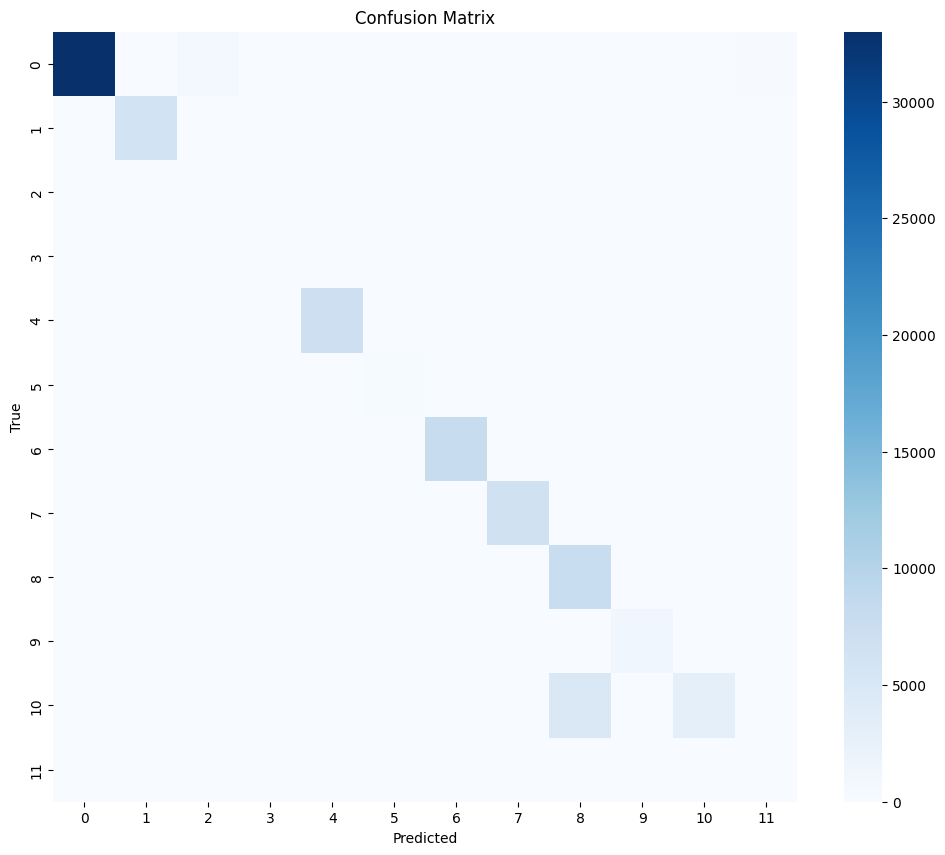


✅ Model and preprocessors saved successfully!


In [5]:
# =============================================
# 3️⃣ FEATURE SELECTION
# =============================================
var_thresh = VarianceThreshold(threshold=0.01)
X_var = var_thresh.fit_transform(X)

selector = SelectKBest(score_func=f_classif, k=min(70, X_var.shape[1]))
X_selected = selector.fit_transform(X_var, y)

# =============================================
# 4️⃣ SCALE FEATURES
# =============================================
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# =============================================
# 5️⃣ TRAIN-TEST SPLIT
# =============================================
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# =============================================
# 6️⃣ BALANCE DATA WITH SMOTE
# =============================================
print("Before SMOTE:", np.bincount(y_train))
smote = SMOTE(random_state=42, k_neighbors=3)
X_train, y_train = smote.fit_resample(X_train, y_train)
print("After SMOTE:", np.bincount(y_train))

# =============================================
# 7️⃣ BUILD MODEL
# =============================================
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(len(le.classes_), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# =============================================
# 8️⃣ TRAIN MODEL
# =============================================
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=512,
    callbacks=[early_stop],
    verbose=1
)

# =============================================
# 9️⃣ EVALUATE MODEL
# =============================================
y_pred = np.argmax(model.predict(X_test), axis=1)

acc = np.round((y_pred == y_test).mean() * 100, 2)
print(f"\n✅ Model Accuracy: {acc}%")

print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=False, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# =============================================
# 🔒 SAVE TRAINED OBJECTS (for later testing)
# =============================================
joblib.dump(le, "label_encoder.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(selector, "selector.pkl")
joblib.dump(var_thresh, "var_thresh.pkl")
joblib.dump(list(X.columns), "trained_columns.pkl")
model.save("ids_deep_model.keras")

print("\n✅ Model and preprocessors saved successfully!")

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 2s 885us/step
Test Accuracy: 92.27%
Classification Report:
                          precision    recall  f1-score   support

                  Benign       1.00      0.96      0.98     34197
                     Bot       0.99      1.00      0.99      6321
        Brute Force -Web       0.09      0.69      0.16       122
        Brute Force -XSS       0.35      0.78      0.48        46
        DDOS attack-HOIC       1.00      1.00      1.00      7213
    DDOS attack-LOIC-UDP       1.00      1.00      1.00       346
  DDoS attacks-LOIC-HTTP       1.00      1.00      1.00      7986
   DoS attacks-GoldenEye       1.00      1.00      1.00      6533
DoS attacks-SlowHTTPTest       0.62      0.98      0.76      7977
   DoS attacks-Slowloris       0.96      1.00      0.98      1262
          FTP-BruteForce       0.96      0.40      0.57      7979
           SQL Injection       0.09      0.94      0.16        17

                accuracy                          

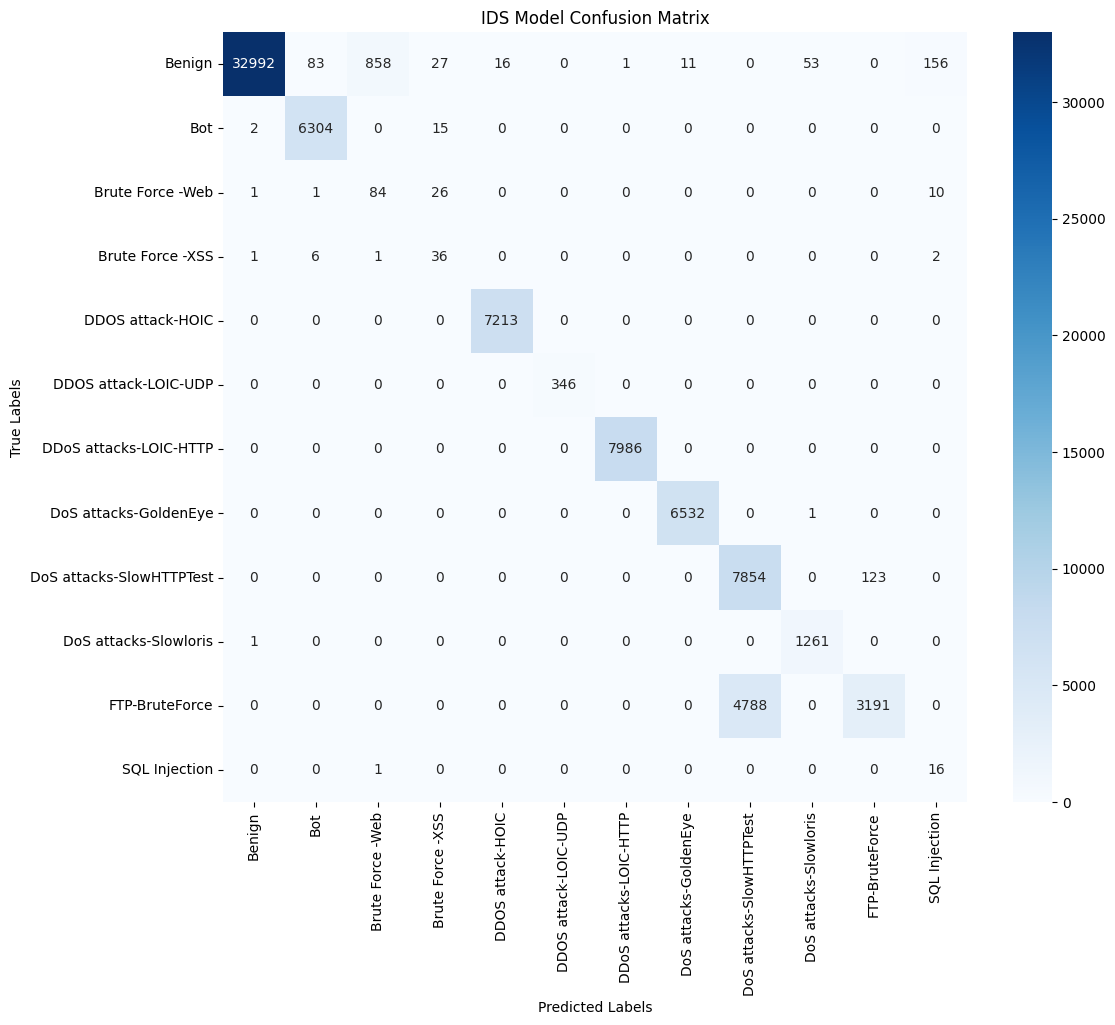

In [6]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have:
# - X_test: your test features, preprocessed
# - y_test: your true test labels
# - model: your trained Keras IDS model
# - le: saved label encoder used for encoding your labels

# Obtain prediction probabilities for test data
y_pred_prob = model.predict(X_test)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Print a detailed classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=[str(c) for c in le.classes_]))

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(c) for c in le.classes_], 
            yticklabels=[str(c) for c in le.classes_])
plt.title('IDS Model Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


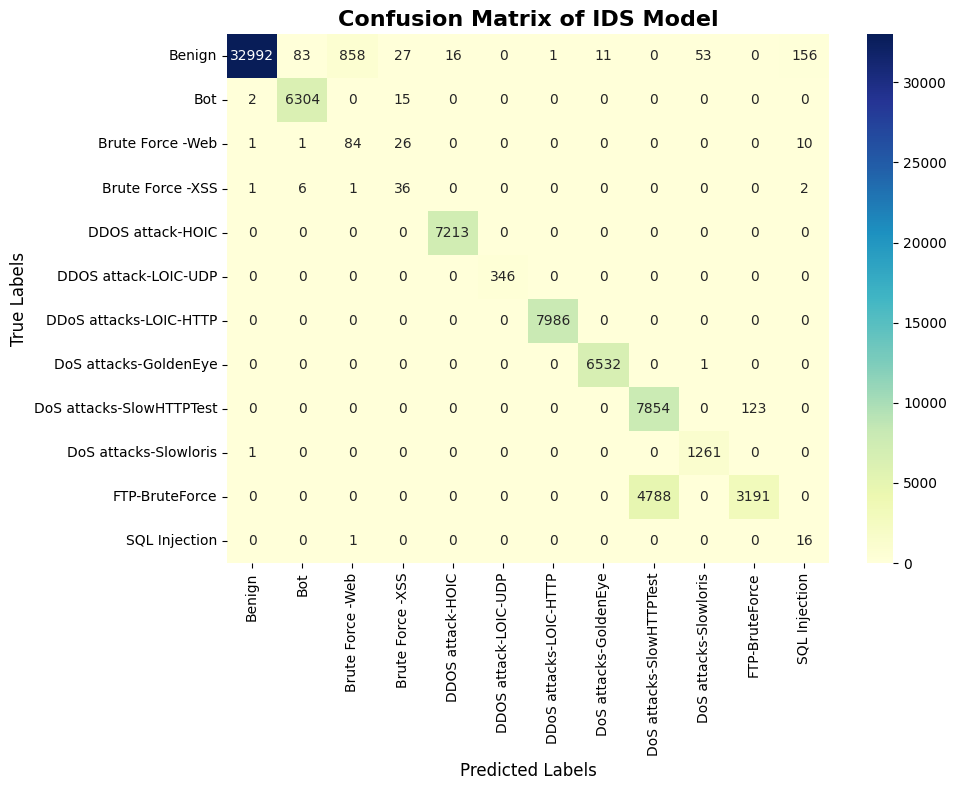

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix of IDS Model", fontsize=16, fontweight='bold')
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)
plt.tight_layout()
plt.show()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step


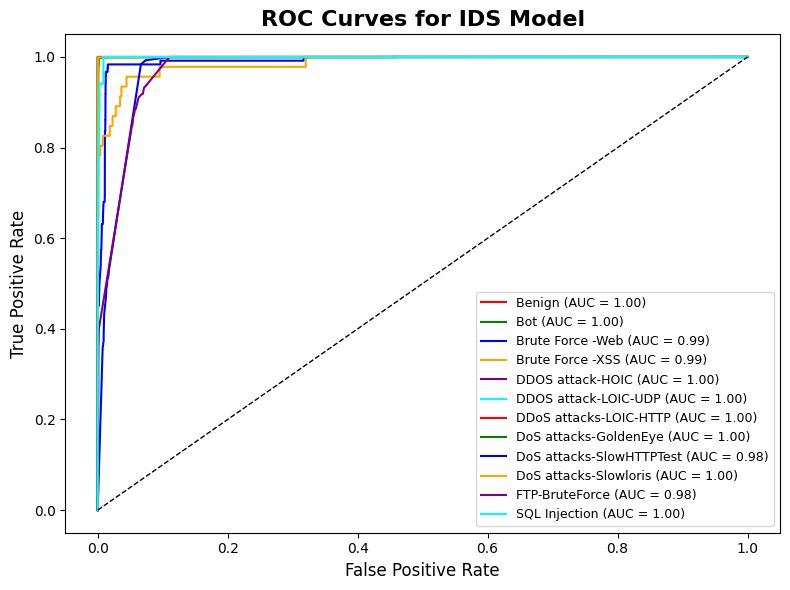

In [10]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import numpy as np

# Binarize labels
y_bin = label_binarize(y_test, classes=np.arange(len(le.classes_)))
y_pred_prob = model.predict(X_test)
fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(le.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, color in zip(range(len(le.classes_)), cycle(['red', 'green', 'blue', 'orange', 'purple', 'cyan'])):
    plt.plot(fpr[i], tpr[i], color=color, lw=1.5,
             label=f"{le.classes_[i]} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title("ROC Curves for IDS Model", fontsize=16, fontweight='bold')
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()


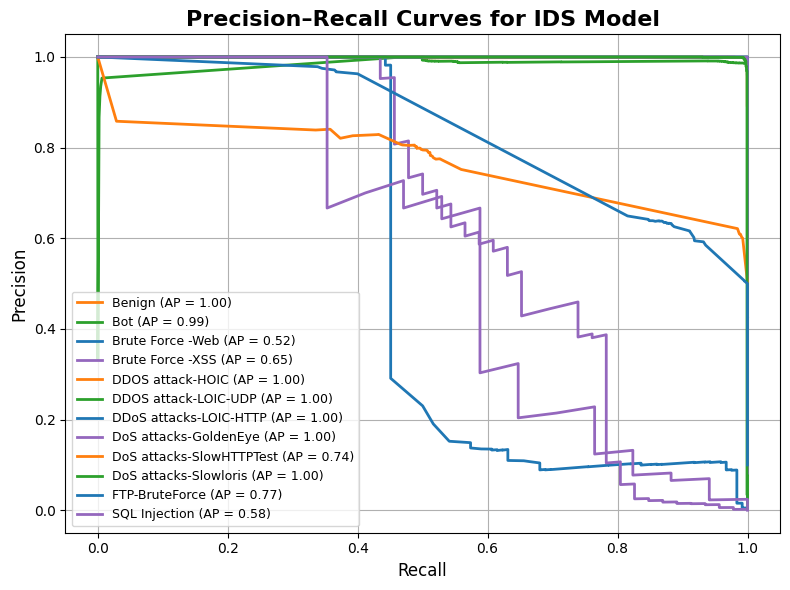

In [11]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i, color in zip(range(len(le.classes_)), cycle(['#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd'])):
    precision, recall, _ = precision_recall_curve(y_bin[:, i], y_pred_prob[:, i])
    avg_precision = average_precision_score(y_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, color=color, lw=2,
             label=f"{le.classes_[i]} (AP = {avg_precision:.2f})")

plt.title("Precision–Recall Curves for IDS Model", fontsize=16, fontweight='bold')
plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.legend(fontsize=9)
plt.grid(True)
plt.tight_layout()
plt.show()


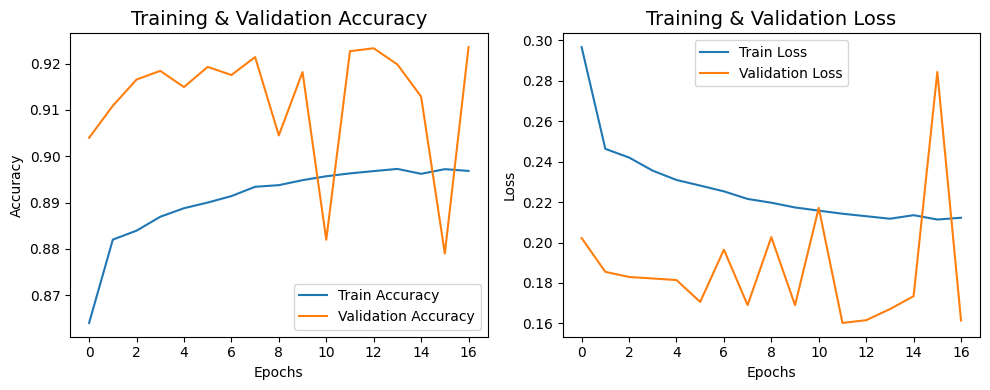

In [13]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


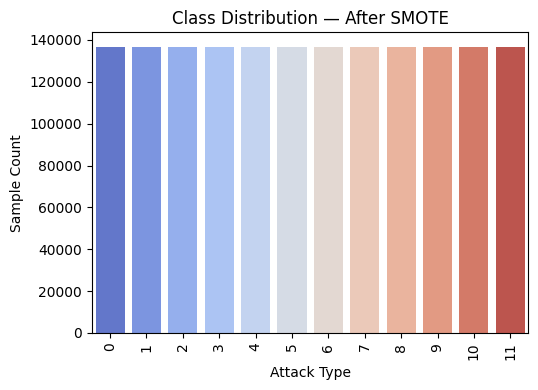

In [14]:
from collections import Counter

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x=list(Counter(y_train).keys()), y=list(Counter(y_train).values()), palette='coolwarm')
plt.title("Class Distribution — After SMOTE")
plt.xlabel("Attack Type")
plt.ylabel("Sample Count")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


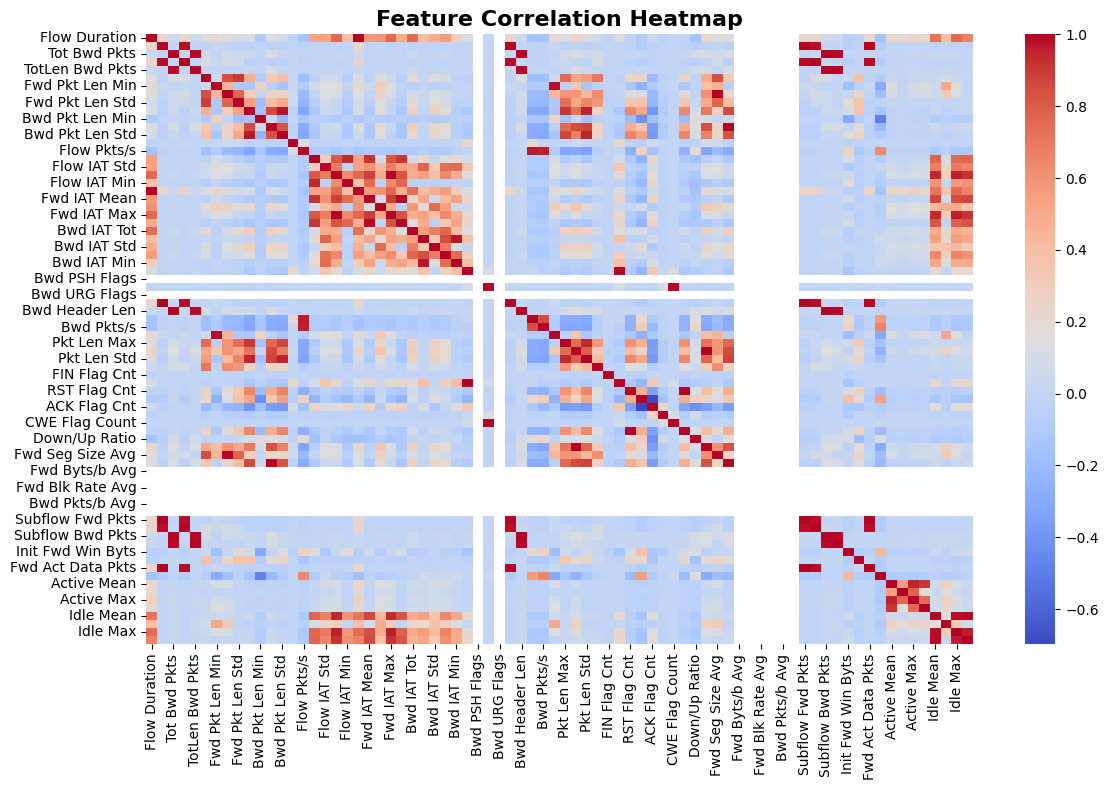

In [15]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd.DataFrame(X, columns=list(X.columns)).corr(), cmap="coolwarm", cbar=True)
plt.title("Feature Correlation Heatmap", fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()
